In [ ]:
from __future__ import division
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt
from scipy import signal

# Parameters

Includes conductances, capicitances, timescales, etc.

In [ ]:
speed=500*um/ms
kij={'ca3pypy':55,'ca3pyin':5}
defaultclock.dt = 0.05*ms
f_s = 1/(defaultclock.dt) #sampling rate in Hertz
Isyn=0*uamp
areapyr=50000*um**2
Ip0=-0.3*nA
gLs=0.1  *msiemens*cm**-2*areapyr
gLd=0.1  *msiemens*cm**-2*areapyr
gNa=30  *msiemens*cm**-2*areapyr
gKdr=15  *msiemens*cm**-2*areapyr
gCa=7  *msiemens*cm**-2*areapyr
gKahp=0.8*msiemens*cm**-2*areapyr  
gKC=15  *msiemens*cm**-2*areapyr
VNa=60*mV
VCa=80*mV
VK=-75*mV
VL=-60*mV
Vsyn=0*mV 
vtsyn=0*mV 
gc=1.75*usiemens
pp=0.5
Cm=3  *uF*cm**-2*areapyr
gNMDA=0*msiemens*cm**-2*areapyr
gampa=0*msiemens*cm**-2*areapyr
gbarsyn=1*nS
tausyn= 2*ms
tauisyn=7*ms
scaler=(10**8*um**2/(areapyr))
'''base values required for buzsaki cells'''
interneuron_size=20000*um**2
Cmi = 1*uF/cm**2*interneuron_size
gL = 0.1*msiemens/cm**2*interneuron_size
VL2 = -65*mV
gNai = 35*msiemens/cm**2*interneuron_size
gKi = 9*msiemens/cm**2*interneuron_size
Esyn=-75*mV
tauisyn=2*ms
sig_py = 10 # pyramidal per mm
sig_in = sig_py / 10 # in per mm
py_per_in = 10;
taguisyn=2*ms
number_of_ca1_py_neurons = 100

Helper function that implements the heaviside function for use with Brian

In [ ]:
@implementation('numpy', discard_units=True)
@check_units(I=1, result=1)
def heav(I):
    return 1 if I >= 0 else 0

## Interneurons

Implemented according to the Buzsaki model. Also positioned similarly to pyramidal cells except there is one interneuron cell per every `py_per_in` pyramidal cells

In [ ]:
start_scope()
buzsaki_eqs = '''
dv/dt = (-gNai*m**3*h*(v-VNa)-gKi*n**4*(v-VK)-gL*(v-VL2)-Issyn-Iinssyn+Iapp2)/Cmi : volt
m = alpha_m/(alpha_m+beta_m) : 1
alpha_m = -0.1/mV*(v+35*mV)/(exp(-0.1/mV*(v+35*mV))-1)/ms : Hz
beta_m = 4*exp(-(v+60*mV)/(18*mV))/ms : Hz
dh/dt = 5*(alpha_h*(1-h)-beta_h*h) : 1
alpha_h = 0.07*exp(-(v+58*mV)/(20*mV))/ms : Hz
beta_h = 1./(exp(-0.1/mV*(v+28*mV))+1)/ms : Hz
dn/dt = 5*(alpha_n*(1-n)-beta_n*n) : 1
alpha_n = -0.01/mV*(v+34*mV)/(exp(-0.1/mV*(v+34*mV))-1)/ms : Hz
beta_n = 0.125*exp(-(v+44*mV)/(80*mV))/ms : Hz
Issyn=gbarsyn*(clip(ssyn,0,7000))*(v-Vsyn): amp
dssyn/dt=-ssyn/tausyn: 1
dinssyn/dt=-inssyn/taguisyn: 1
Iinssyn=gbarsyn*clip(inssyn,0,7000)*(v-VK):amp
pos: 1
Iapp2: amp
'''
number_of_ca1_in_neurons =  1000
CA1_interneuron=NeuronGroup(number_of_ca1_in_neurons, buzsaki_eqs,threshold='v>-20*mV',refractory='3*ms',method='euler')
CA1_interneuron.v='(randn()*60*.05-60)*mV'
CA1_interneuron.h=.999
CA1_interneuron.n=.0001
CA1_interneuron.ssyn=0
CA1_interneuron.pos = 'i* (1.0/sig_py) * py_per_in'

WARNING    The expression "py_per_in / sig_py" divides two integer values. In previous versions of Brian, this would have used either an integer ("flooring") or a floating point division, depending on the Python version and the code generation target. In the current version, it always uses a floating point division. Explicitly ask for an  integer division ("//"), or turn one of the operands into a floating point value (e.g. replace "1/2" by "1.0/2") to no longer receive this warning. [brian2.parsing.bast.floating_point_division]


## Synapses
### Interneuron to Interneuron

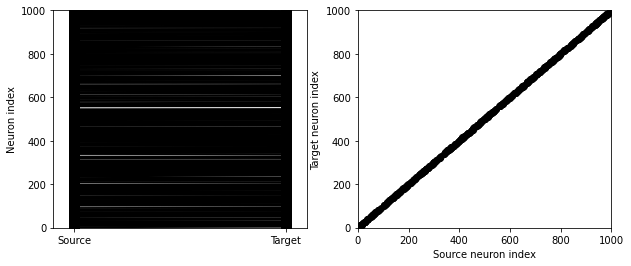

In [ ]:
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    
p_in_has_syn_to_in = 0.8
CA1_in_in = Synapses(CA1_interneuron,CA1_interneuron, on_pre='ssyn_post+=2.5')
CA1_in_in.connect('i!=j', p='(p_in_has_syn_to_in*1.0/(sqrt(2.0*pi)*sig_in)*exp(-((pos_pre-pos_post)**2/(2*sig_in**2))))')
visualise_connectivity(CA1_in_in)

## Expected Behavior

Here we will validate some results by Taxidis et. al. regarding the CA1 network in isolation

In [ ]:
spikemon = SpikeMonitor(CA1_interneuron)
statemon = StateMonitor(CA1_interneuron,True,record=True)
duration=500*ms
CA1_interneuron.Iapp2 = 0.3 * nA
run(duration)

In [ ]:
# plt.figure(figsize=(20,5))
# idx = np.where(spikemon.t/ms <= duration/ms)[0]
# plot((spikemon.t/ms)[idx], spikemon.i[idx], '.k')
# xlabel('Time (ms)')
# ylabel('Neuron index');
# title("Raster plot of CA1 Interneurons")

In [ ]:
# idx = np.where(statemon.t/ms <= 50)[0]
# avg_v = np.average(statemon.v, axis = 0)
# plot((statemon.t/ms)[idx], avg_v[idx]/mV, '.k')
# xlabel('Time (ms)')
# ylabel('Voltage (mV)');
# title("Average membrane potential across population of CA1 Interneurons")
# plt.savefig(f"AvgMemPot{number_of_ca1_in_neurons}CA1Neurons.png")

In [ ]:
# # Number of samples
# N = duration * f_s
# N = int(N)
# print(N)
# yf = fft(avg_v)
# xf = fftfreq(N, 1 / f_s)

# plt.xlabel('freq (Hz)')
# plt.plot(xf, np.abs(yf))
# plt.show()

In [ ]:
# f, t, Sxx = signal.spectrogram(avg_v, f_s)
# plt.pcolormesh(t, f, Sxx, shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.ylim((0,300))
# plt.colorbar()
# plt.savefig(f"Spectrogram_{number_of_ca1_in_neurons}CA1Neurons.png")
# plt.show()

## Power Spectral Density of Interneurons

Computes the PSD of CA1 Interneurons as well as the sum of the power in the ripple band

In [ ]:
# lower_ripple_freq = 100 * Hz
# upper_ripple_freq = 300 * Hz
# f, Pxx_den = signal.welch(avg_v, f_s) #use Welch's method to perform PSD

# ripple_band_power = 0

# #sum the powers of the frequencies in the ripple band
# for freq in f:
#     if lower_ripple_freq < freq < upper_ripple_freq:
#         ripple_band_power += Pxx_den[np.where(f==freq)]  
# print(ripple_band_power)  

# plt.semilogy(f, Pxx_den)

# #plt.ylim([0.5e-3, 1])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
# #plt.xlim((150,200))
# #plt.savefig(f"PSD_{number_of_ca1_in_neurons}CA1Neurons.png")
# plt.show()

In [ ]:
# f, Pxx_spec = signal.welch(avg_v, f_s, 'flattop', 1024, scaling='spectrum')
# plt.figure()
# plt.semilogy(f, np.sqrt(Pxx_spec))
# plt.xlabel('frequency [Hz]')
# plt.ylabel('Linear spectrum [V RMS]')
# plt.show()

In [ ]:
def get_ripple_band_power(N, p_connect = 0.8, duration=50, lower_ripple_freq=150, upper_ripple_freq=200, lin_style = '.k'):
    '''
    Computes ripple band power as a function of number of interneurons in the network
    N: number of interneurons in the network (int)
    p_connect: probability of connection between two interneurons (float)
    duration: how long a generated signal is in milliseconds (int). Defaults to 50 ms.
    lower_ripple_freq: The lower frequency limit in Hertz of how the authors define a SPW-R (int). Defaults to 150 Hz.
    upper_ripple_freq: The upper frequency limit in Hertz of how the authors define a SPW-R (int). Defaults to 200 Hz.
    '''
    start_scope()
    #create interneuron group
    CA1_interneuron=NeuronGroup(N, buzsaki_eqs,threshold='v>-20*mV',refractory='3*ms',method='euler')
    CA1_interneuron.v='(randn()*60*.05-60)*mV'
    CA1_interneuron.h=.999
    CA1_interneuron.n=.0001
    CA1_interneuron.ssyn=0
    CA1_interneuron.pos = 'i* (1.0/sig_py) * py_per_in'

    #create connections between interneurons
    CA1_in_in = Synapses(CA1_interneuron,CA1_interneuron, on_pre='ssyn_post+=2.5')
    CA1_in_in.connect('i!=j', p='(p_connect*1.0/(sqrt(2.0*pi)*sig_in)*exp(-((pos_pre-pos_post)**2/(2*sig_in**2))))')
    
    #run the CA1 simulation, create spikes for each state
    spikemon = SpikeMonitor(CA1_interneuron)
    statemon = StateMonitor(CA1_interneuron,True,record=True)
    duration=duration*ms
    CA1_interneuron.Iapp2 = 0.3 * nA
    run(duration)

    #get average membrane potential for each state
    avg_v = np.average(statemon.v, axis = 0)
    idx = np.where(statemon.t/ms <= 50)[0]

    plt.plot((statemon.t/ms)[idx], avg_v[idx]/mV, lin_style)
    xlabel('Time (ms)')
    ylabel('Voltage (mV)');
    title(f"Average membrane potential across population of {N} CA1 Interneurons with Synapse Probability of {p_connect}")
    plt.savefig(f'AvgMemPotFor{N}InterNeuronsAndSynapseProbOf{p_connect}.png')
    
    lower_ripple_freq = lower_ripple_freq * Hz
    upper_ripple_freq = upper_ripple_freq * Hz
    f, Pxx_den = signal.welch(avg_v, f_s) #use Welch's method to perform PSD

    ripple_band_power = 0

    #sum the powers of the frequencies in the ripple band
    for freq in f:
        if lower_ripple_freq < freq < upper_ripple_freq:
            ripple_band_power += Pxx_den[np.where(f==freq)] 
    return ripple_band_power


array([1.10123962e-07])

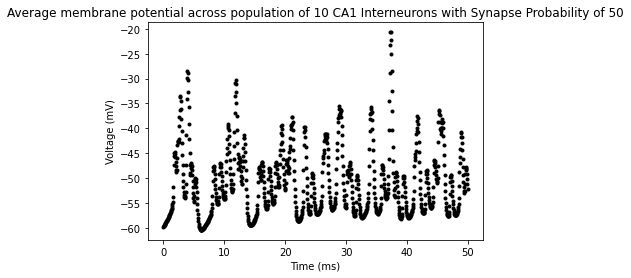

In [ ]:
get_ripple_band_power(10, 50)

No handles with labels found to put in legend.


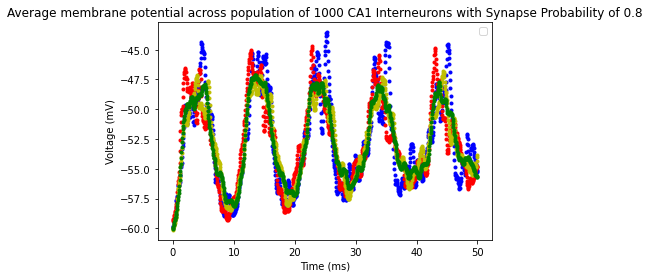

In [ ]:
get_ripple_band_power(100, p_connect = 0.8, duration=50, lin_style = '.b')
get_ripple_band_power(200, p_connect = 0.8, duration=50, lin_style = '.r')
get_ripple_band_power(500, p_connect = 0.8, duration=50, lin_style = '.y')
get_ripple_band_power(1000, p_connect = 0.8, duration=50, lin_style = '.g')
plt.legend()

No handles with labels found to put in legend.


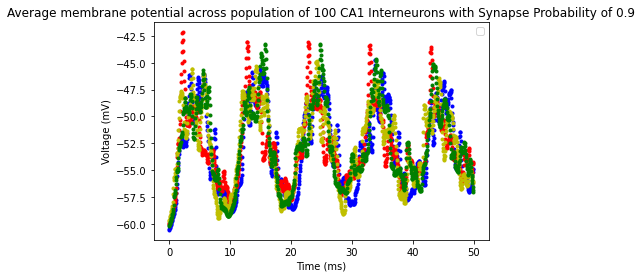

In [ ]:
get_ripple_band_power(100, p_connect = 0.2, duration=50, lin_style = '.b')
get_ripple_band_power(100, p_connect = 0.5, duration=50, lin_style = '.r')
get_ripple_band_power(100, p_connect = 0.7, duration=50, lin_style = '.y')
get_ripple_band_power(100, p_connect = 0.9, duration=50, lin_style = '.g')
plt.legend()

array([5.52576771e-08])

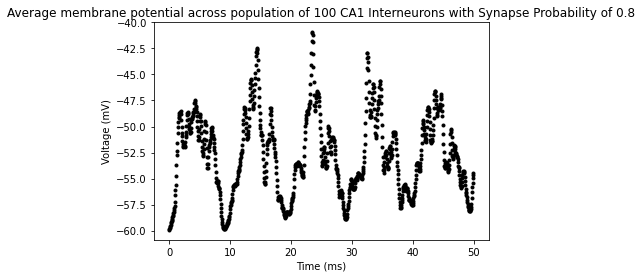

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
get_ripple_band_power(N=40000, p_connect = 0.8, duration=50)

In [ ]:
p_list = 

[  50  150  250  350  450  550  650  750  850  950 1050 1150 1250 1350
 1450]


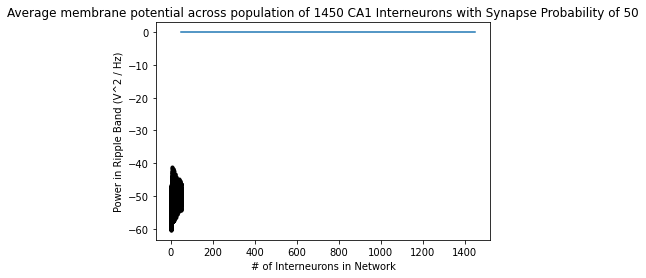

In [ ]:
# N_list = np.arange(50, 1500, 100)
# print(N_list)
# power_list = []

# for N in N_list:
#     power_list.append(get_ripple_band_power(N, 50))
# plt.plot(N_list, power_list)

# plt.ylabel("Power in Ripple Band (V^2 / Hz)")
# plt.xlabel('# of Interneurons in Network')
# plt.savefig('PowerVsInterneuronNumber.png')

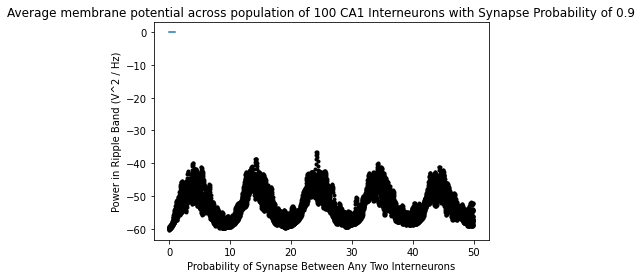

In [ ]:
# p_list = np.arange(0, 1, 0.1)

# power_list = []

# for p in p_list:
#     power_list.append(get_ripple_band_power(N=100, p_connect = p, duration=50))

# plt.plot(p_list, power_list)

# plt.ylabel('Power in Ripple Band (V^2 / Hz)')
# plt.xlabel('Probability of Synapse Between Any Two Interneurons')
# plt.savefig('PowerVsSynapseProbability.png')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3eff106f-d848-4b03-a3de-e386afb78d06' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>